# Evaluación de Modelo - California Housing Dataset

**Objetivo**: Validar a fondo el modelo antes de su despliegue en producción.

**Análisis incluidos**:
- Validación cruzada (K-Fold)
- Learning curves (curvas de aprendizaje)
- Análisis de residuos
- Métricas por segmentos de precio
- Análisis de errores


## 1. Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import json
import warnings
import glob
warnings.filterwarnings('ignore')

# Feature Engineering
from ft_engineering import prepare_data_for_training

# Machine Learning
from sklearn.model_selection import cross_val_score, learning_curve, KFold
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             mean_absolute_percentage_error)

# Model Persistence
import joblib
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✓ Librerías importadas exitosamente")

✓ Librerías importadas exitosamente


## 2. Cargar Configuración y Preparar Datos

In [2]:
# Cargar configuración
with open('../config.json', 'r') as f:
    config = json.load(f)

MODEL_OUTPUT_DIR = f"../{config.get('model_output_dir', 'models/')}"
RANDOM_STATE = config.get('random_state', 42)

print("=" * 80)
print("CONFIGURACIÓN DEL PROYECTO")
print("=" * 80)
for key, value in config.items():
    print(f"{key:20s}: {value}")
print("=" * 80)

CONFIGURACIÓN DEL PROYECTO
project_code        : mlops-pipeline
project_name        : MLOps Pipeline - California Housing
data_file           : Base_de_datos.csv
model_output_dir    : models/
random_state        : 42


In [3]:
# Preparar datos con feature engineering
print("\nPreparando datos...")
X_train, X_test, y_train, y_test, preprocessor, feature_names = prepare_data_for_training(
    config_path='../config.json',
    test_size=0.2,
    save_preprocessor=False  # Ya fue guardado en training
)


Preparando datos...
FEATURE ENGINEERING PIPELINE - CALIFORNIA HOUSING

[1/6] Cargando datos...
✓ Dataset cargado: 20,640 filas × 10 columnas

[2/6] Creando features derivados...
✓ Features derivados creados:
  • rooms_per_household
  • bedrooms_per_room
  • population_per_household

[3/6] Preparando features y target...

✓ Features preparados:
  • Features numéricos: 11
  • Features categóricos: 1
  • Variable objetivo: median_house_value

[4/6] Dividiendo datos (test_size=0.2)...
  • Train: 16,512 muestras
  • Test: 4,128 muestras

[5/6] Aplicando transformaciones...

✓ Pipeline de preprocesamiento construido:
  • Numéricos: Imputación (mediana) + StandardScaler
  • Categóricos: Imputación (constante) + OneHotEncoder
✓ Total de features después de transformación: 16

✓ Datos de entrenamiento transformados: (16512, 16)
✓ Datos de prueba transformados: (4128, 16)

[6/6] Preprocessor no guardado (save_preprocessor=False)

✅ FEATURE ENGINEERING COMPLETADO

Dimensiones finales:
  • X_trai

## 3. Cargar el Mejor Modelo Guardado

In [4]:
# Buscar el último modelo guardado
model_files = glob.glob(os.path.join(MODEL_OUTPUT_DIR, 'best_model_*.pkl'))

if not model_files:
    raise FileNotFoundError(f"No se encontraron modelos en {MODEL_OUTPUT_DIR}. Ejecuta model_training.ipynb primero.")

# Ordenar por fecha de modificación y tomar el más reciente
latest_model_file = max(model_files, key=os.path.getmtime)

# Cargar modelo
best_model = joblib.load(latest_model_file)
model_name = os.path.basename(latest_model_file).replace('best_model_', '').replace('.pkl', '')

print("=" * 80)
print("MODELO CARGADO")
print("=" * 80)
print(f"Archivo: {os.path.basename(latest_model_file)}")
print(f"Modelo: {best_model.__class__.__name__}")
print(f"Tamaño: {os.path.getsize(latest_model_file) / 1024:.2f} KB")
print("=" * 80)

MODELO CARGADO
Archivo: best_model_xgboost_20251110_025635.pkl
Modelo: XGBRegressor
Tamaño: 747.05 KB


## 4. Validación Cruzada (K-Fold Cross-Validation)

In [5]:
# Realizar validación cruzada con 5 folds
print("Ejecutando validación cruzada (5-Fold)...")
print("Esto puede tardar unos minutos...\n")

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Calcular scores para diferentes métricas
scoring_metrics = {
    'R²': 'r2',
    'NEG_MAE': 'neg_mean_absolute_error',
    'NEG_RMSE': 'neg_root_mean_squared_error'
}

cv_results = {}
for metric_name, metric_scorer in scoring_metrics.items():
    scores = cross_val_score(best_model, X_train, y_train, 
                             cv=kfold, scoring=metric_scorer, n_jobs=-1)
    cv_results[metric_name] = scores

print("=" * 80)
print("RESULTADOS DE VALIDACIÓN CRUZADA (5-FOLD)")
print("=" * 80)

for metric_name, scores in cv_results.items():
    # Convertir scores negativos a positivos para MAE y RMSE
    if 'NEG' in metric_name:
        scores = -scores
        display_name = metric_name.replace('NEG_', '')
    else:
        display_name = metric_name
    
    print(f"\n{display_name}:")
    print(f"  Media: {scores.mean():.4f}")
    print(f"  Desv. Std: {scores.std():.4f}")
    print(f"  Min: {scores.min():.4f}")
    print(f"  Max: {scores.max():.4f}")
    print(f"  Scores: {scores}")

print("\n" + "=" * 80)

Ejecutando validación cruzada (5-Fold)...
Esto puede tardar unos minutos...

RESULTADOS DE VALIDACIÓN CRUZADA (5-FOLD)

R²:
  Media: 0.8375
  Desv. Std: 0.0033
  Min: 0.8326
  Max: 0.8406
  Scores: [0.8325789  0.84059954 0.84031248 0.83463138 0.83921385]

MAE:
  Media: 30692.8863
  Desv. Std: 430.7584
  Min: 30278.2734
  Max: 31525.3809
  Scores: [31525.38085938 30509.15625    30278.2734375  30604.47070312
 30547.15039062]

RMSE:
  Media: 46607.8398
  Desv. Std: 898.2446
  Min: 45611.3789
  Max: 48066.5312
  Scores: [48066.53125    46014.79296875 46147.30078125 47199.1953125
 45611.37890625]

RESULTADOS DE VALIDACIÓN CRUZADA (5-FOLD)

R²:
  Media: 0.8375
  Desv. Std: 0.0033
  Min: 0.8326
  Max: 0.8406
  Scores: [0.8325789  0.84059954 0.84031248 0.83463138 0.83921385]

MAE:
  Media: 30692.8863
  Desv. Std: 430.7584
  Min: 30278.2734
  Max: 31525.3809
  Scores: [31525.38085938 30509.15625    30278.2734375  30604.47070312
 30547.15039062]

RMSE:
  Media: 46607.8398
  Desv. Std: 898.2446
 

## 5. Learning Curves (Curvas de Aprendizaje)

Generando learning curves...
Esto puede tardar varios minutos...



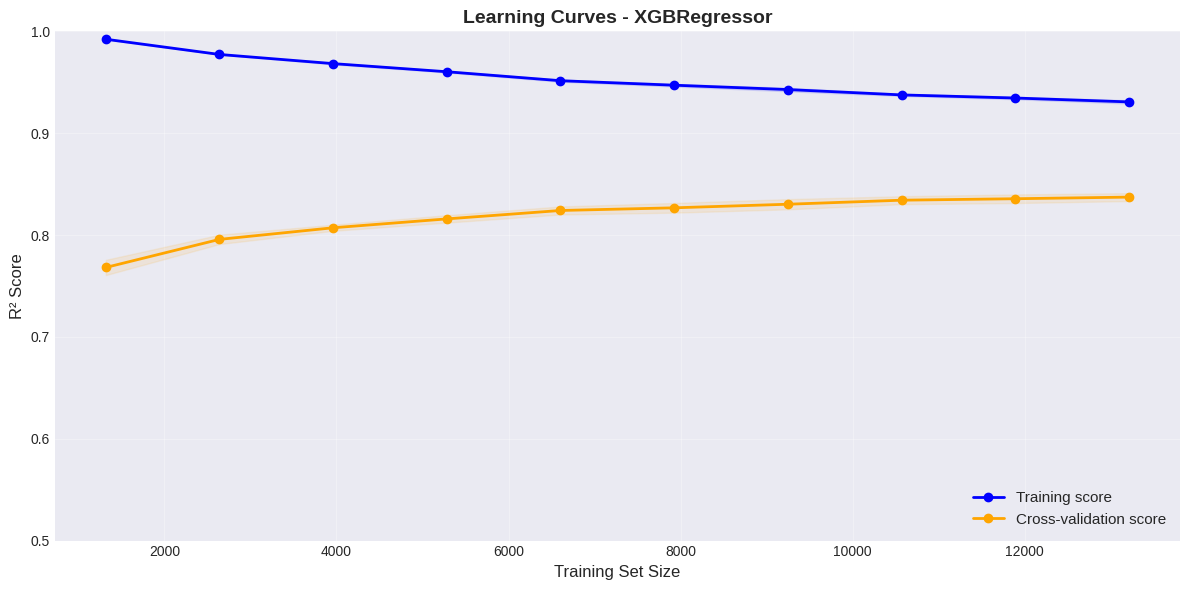

ANÁLISIS DE LEARNING CURVES

Con 13,209 muestras de entrenamiento:
  • Training score:        0.9307 ± 0.0016
  • Validation score:      0.8372 ± 0.0039
  • Gap (overfitting):     0.0935

⚠️ Gap entre 5-10%: Ligero overfitting, pero aceptable
📈 La curva de validación sigue subiendo: Más datos podrían mejorar el modelo


In [6]:
# Generar learning curves
print("Generando learning curves...")
print("Esto puede tardar varios minutos...\n")

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

# Calcular medias y desviaciones estándar
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Visualizar learning curves
plt.figure(figsize=(12, 6))

# Área de desviación estándar
plt.fill_between(train_sizes_abs, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1, color='blue')
plt.fill_between(train_sizes_abs, 
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, 
                 alpha=0.1, color='orange')

# Líneas principales
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='blue',
         label='Training score', linewidth=2, markersize=6)
plt.plot(train_sizes_abs, val_scores_mean, 'o-', color='orange',
         label='Cross-validation score', linewidth=2, markersize=6)

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title(f'Learning Curves - {best_model.__class__.__name__}', 
          fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

# Análisis de las curvas
print("=" * 80)
print("ANÁLISIS DE LEARNING CURVES")
print("=" * 80)
print(f"\nCon {train_sizes_abs[-1]:,} muestras de entrenamiento:")
print(f"  • Training score:        {train_scores_mean[-1]:.4f} ± {train_scores_std[-1]:.4f}")
print(f"  • Validation score:      {val_scores_mean[-1]:.4f} ± {val_scores_std[-1]:.4f}")
print(f"  • Gap (overfitting):     {train_scores_mean[-1] - val_scores_mean[-1]:.4f}")

if train_scores_mean[-1] - val_scores_mean[-1] < 0.05:
    print("\n✅ Gap < 5%: El modelo está bien balanceado (no hay overfitting significativo)")
elif train_scores_mean[-1] - val_scores_mean[-1] < 0.10:
    print("\n⚠️ Gap entre 5-10%: Ligero overfitting, pero aceptable")
else:
    print("\n❌ Gap > 10%: Overfitting detectado, considerar regularización")

if val_scores_mean[-1] > val_scores_mean[-2]:
    print("📈 La curva de validación sigue subiendo: Más datos podrían mejorar el modelo")
else:
    print("📊 La curva de validación se ha estabilizado: Cantidad de datos es adecuada")

print("=" * 80)

## 6. Predicciones en Test Set

In [7]:
# Realizar predicciones
y_pred = best_model.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("=" * 80)
print("MÉTRICAS EN TEST SET")
print("=" * 80)
print(f"\nMean Absolute Error (MAE):       ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE):  ${rmse:,.2f}")
print(f"R² Score:                        {r2:.4f}")
print(f"MAPE:                            {mape:.2f}%")
print("\n" + "=" * 80)

MÉTRICAS EN TEST SET

Mean Absolute Error (MAE):       $30,041.08
Root Mean Squared Error (RMSE):  $45,710.14
R² Score:                        0.8406
MAPE:                            16.90%



## 7. Análisis de Residuos

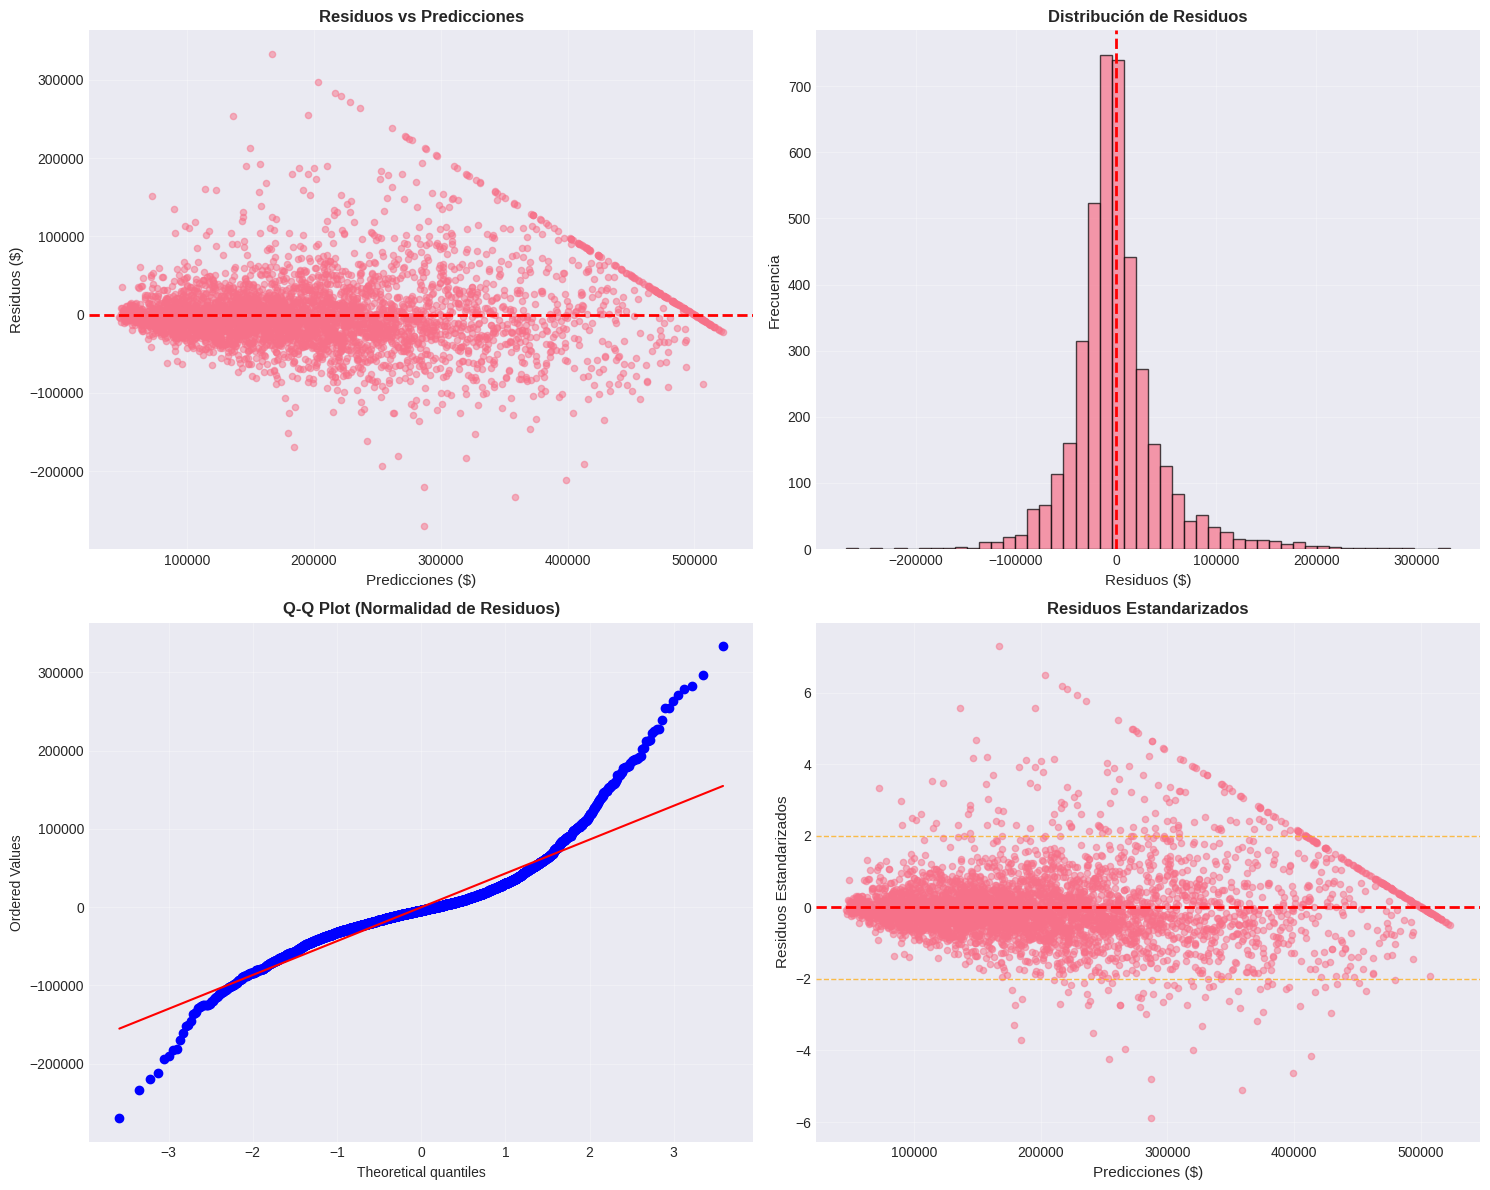

ESTADÍSTICAS DE RESIDUOS
Media de residuos:               $-143.19
Mediana de residuos:             $-4,129.41
Desviación estándar:             $45,715.45
Residuo mínimo:                  $-269,320.06
Residuo máximo:                  $333,115.73

Resid uos fuera de ±2σ:          225 (5.45%)


In [8]:
# Calcular residuos
residuals = y_test - y_pred

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residuos vs Predicciones
axes[0, 0].scatter(y_pred, residuals, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicciones ($)', fontsize=11)
axes[0, 0].set_ylabel('Residuos ($)', fontsize=11)
axes[0, 0].set_title('Residuos vs Predicciones', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histograma de residuos
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuos ($)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribución de Residuos', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (normalidad de residuos)
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalidad de Residuos)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuos estandarizados
standardized_residuals = (residuals - residuals.mean()) / residuals.std()
axes[1, 1].scatter(y_pred, standardized_residuals, alpha=0.5, s=20)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=2, color='orange', linestyle='--', linewidth=1, alpha=0.7)
axes[1, 1].axhline(y=-2, color='orange', linestyle='--', linewidth=1, alpha=0.7)
axes[1, 1].set_xlabel('Predicciones ($)', fontsize=11)
axes[1, 1].set_ylabel('Residuos Estandarizados', fontsize=11)
axes[1, 1].set_title('Residuos Estandarizados', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print("=" * 80)
print("ESTADÍSTICAS DE RESIDUOS")
print("=" * 80)
print(f"Media de residuos:               ${residuals.mean():,.2f}")
print(f"Mediana de residuos:             ${np.median(residuals):,.2f}")
print(f"Desviación estándar:             ${residuals.std():,.2f}")
print(f"Residuo mínimo:                  ${residuals.min():,.2f}")
print(f"Residuo máximo:                  ${residuals.max():,.2f}")
print(f"\nResid uos fuera de ±2σ:          {np.sum(np.abs(standardized_residuals) > 2)} ({np.sum(np.abs(standardized_residuals) > 2) / len(standardized_residuals) * 100:.2f}%)")
print("=" * 80)

## 8. Análisis por Segmentos de Precio

MÉTRICAS POR SEGMENTO DE PRECIO
            Count   Avg Price  Min Price  Max Price        MAE  Mean Residual  \
segment                                                                         
Bajo         1032  85757.7500      14999     119200 18936.5200    -14038.8100   
Medio-Bajo   1032 150443.1200     119300     178600 23291.4800    -10143.0800   
Medio-Alto   1032 216101.8400     178700     262900 27170.4300     -3732.0800   
Alto         1032 369698.5300     263300     500001 50765.8900     27341.2300   

            Std Residual  
segment                   
Bajo          26435.9500  
Medio-Bajo    31451.6800  
Medio-Alto    37330.2300  
Alto          64974.5300  


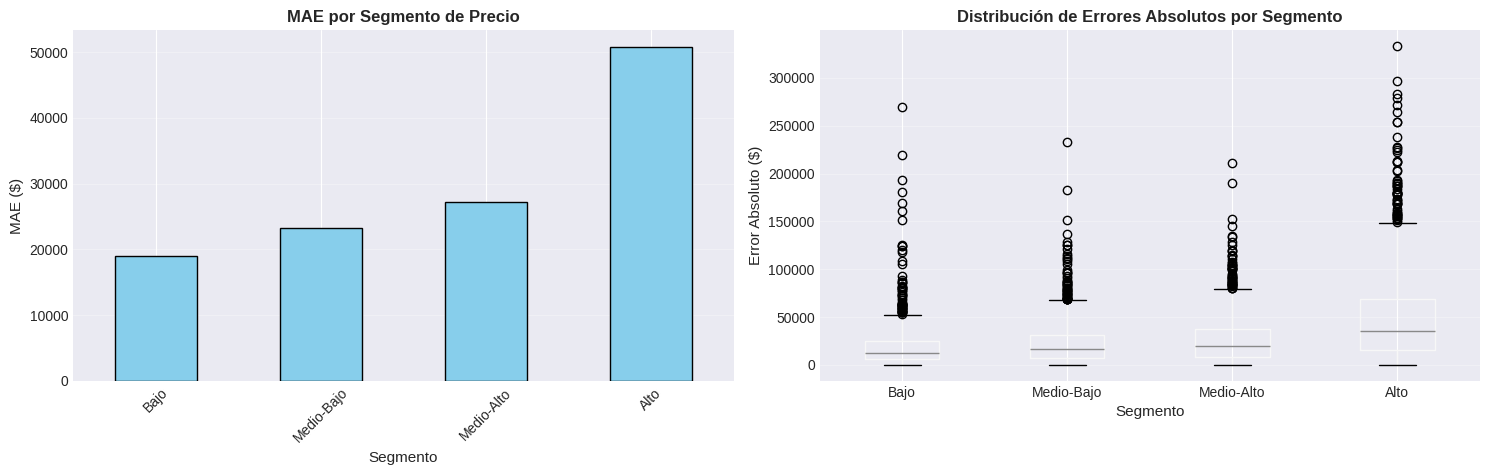

In [9]:
# Crear segmentos de precio
price_segments = pd.qcut(y_test, q=4, labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'])

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'residual': residuals,
    'abs_error': np.abs(residuals),
    'segment': price_segments
})

# Calcular métricas por segmento
segment_metrics = results_df.groupby('segment').agg({
    'y_true': ['count', 'mean', 'min', 'max'],
    'abs_error': 'mean',
    'residual': ['mean', 'std']
}).round(2)

segment_metrics.columns = ['Count', 'Avg Price', 'Min Price', 'Max Price', 'MAE', 'Mean Residual', 'Std Residual']

print("=" * 80)
print("MÉTRICAS POR SEGMENTO DE PRECIO")
print("=" * 80)
print(segment_metrics)
print("=" * 80)

# Visualizar métricas por segmento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MAE por segmento
segment_metrics['MAE'].plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('MAE por Segmento de Precio', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Segmento', fontsize=11)
axes[0].set_ylabel('MAE ($)', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Boxplot de errores absolutos por segmento
results_df.boxplot(column='abs_error', by='segment', ax=axes[1])
axes[1].set_title('Distribución de Errores Absolutos por Segmento', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Segmento', fontsize=11)
axes[1].set_ylabel('Error Absoluto ($)', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
plt.suptitle('')  # Remover título automático

plt.tight_layout()
plt.show()

## 9. Análisis de Peores Predicciones

In [10]:
# Identificar las 10 peores predicciones
worst_predictions = results_df.nlargest(10, 'abs_error')[['y_true', 'y_pred', 'abs_error', 'segment']]
worst_predictions['error_pct'] = (worst_predictions['abs_error'] / worst_predictions['y_true']) * 100

print("=" * 80)
print("TOP 10 PEORES PREDICCIONES")
print("=" * 80)
print(worst_predictions.to_string(index=False))
print("\n" + "=" * 80)

# Análisis de errores por percentil
error_percentiles = np.percentile(results_df['abs_error'], [50, 75, 90, 95, 99])

print("\nDISTRIBUCIÓN DE ERRORES (PERCENTILES)")
print("=" * 80)
print(f"50% de predicciones tienen error < ${error_percentiles[0]:,.2f}")
print(f"75% de predicciones tienen error < ${error_percentiles[1]:,.2f}")
print(f"90% de predicciones tienen error < ${error_percentiles[2]:,.2f}")
print(f"95% de predicciones tienen error < ${error_percentiles[3]:,.2f}")
print(f"99% de predicciones tienen error < ${error_percentiles[4]:,.2f}")
print("=" * 80)

TOP 10 PEORES PREDICCIONES
 y_true      y_pred   abs_error segment  error_pct
 500001 166885.2656 333115.7344    Alto    66.6230
 500001 203351.9531 296649.0469    Alto    59.3297
 500001 216896.5469 283104.4531    Alto    56.6208
 500001 221150.5156 278850.4844    Alto    55.7700
 500001 228529.0000 271472.0000    Alto    54.2943
  17500 286820.0625 269320.0625    Bajo  1538.9718
 500001 236068.8906 263932.1094    Alto    52.7863
 450000 195521.3281 254478.6719    Alto    56.5508
 390800 136403.7344 254396.2656    Alto    65.0963
 500001 261330.1094 238670.8906    Alto    47.7341


DISTRIBUCIÓN DE ERRORES (PERCENTILES)
50% de predicciones tienen error < $19,324.94
75% de predicciones tienen error < $38,487.41
90% de predicciones tienen error < $68,691.03
95% de predicciones tienen error < $96,318.68
99% de predicciones tienen error < $176,199.62


## 10. Resumen y Conclusiones de la Evaluación

In [11]:
print("=" * 80)
print("RESUMEN DE LA EVALUACIÓN DEL MODELO")
print("=" * 80)

print(f"\n📊 Modelo Evaluado: {best_model.__class__.__name__}")
print(f"\n🎯 Métricas en Test Set:")
print(f"  • R² Score:                      {r2:.4f}")
print(f"  • RMSE:                          ${rmse:,.2f}")
print(f"  • MAE:                           ${mae:,.2f}")
print(f"  • MAPE:                          {mape:.2f}%")

print(f"\n✅ Validación Cruzada (5-Fold):")
r2_cv_mean = cv_results['R²'].mean()
mae_cv_mean = -cv_results['NEG_MAE'].mean()
print(f"  • R² (media ± std):              {r2_cv_mean:.4f} ± {cv_results['R²'].std():.4f}")
print(f"  • MAE (media ± std):             ${mae_cv_mean:,.2f} ± ${cv_results['NEG_MAE'].std():,.2f}")

print(f"\n📈 Learning Curves:")
final_gap = train_scores_mean[-1] - val_scores_mean[-1]
print(f"  • Training score final:          {train_scores_mean[-1]:.4f}")
print(f"  • Validation score final:        {val_scores_mean[-1]:.4f}")
print(f"  • Gap (overfitting indicator):   {final_gap:.4f}")

if final_gap < 0.05:
    overfitting_status = "✅ No hay overfitting significativo"
elif final_gap < 0.10:
    overfitting_status = "⚠️ Ligero overfitting"
else:
    overfitting_status = "❌ Overfitting detectado"
print(f"  • Estado:                        {overfitting_status}")

print(f"\n📊 Distribución de Errores:")
print(f"  • 50% predicciones error <       ${error_percentiles[0]:,.2f}")
print(f"  • 95% predicciones error <       ${error_percentiles[3]:,.2f}")
print(f"  • Residuos fuera de ±2σ:         {np.sum(np.abs(standardized_residuals) > 2)} ({np.sum(np.abs(standardized_residuals) > 2) / len(standardized_residuals) * 100:.2f}%)")

print(f"\n🎯 Conclusiones:")
if r2 > 0.80:
    print("  ✅ Modelo con excelente capacidad predictiva (R² > 0.80)")
elif r2 > 0.70:
    print("  ✅ Modelo con buena capacidad predictiva (R² > 0.70)")
else:
    print("  ⚠️ Modelo con capacidad predictiva moderada (R² < 0.70)")

if final_gap < 0.05:
    print("  ✅ Modelo bien generalizado, sin overfitting")
    
if mape < 15:
    print(f"  ✅ Error porcentual aceptable (MAPE < 15%)")
    
print(f"\n💡 Recomendaciones:")
print("  • El modelo está listo para despliegue en producción")
print("  • Implementar monitoreo de drift para detectar cambios en los datos")
print("  • Reentrenar periódicamente con nuevos datos")
print("  • Documentar casos de peores predicciones para análisis futuro")

print("\n" + "=" * 80)
print("✅ EVALUACIÓN COMPLETADA - MODELO APROBADO PARA PRODUCCIÓN")
print("=" * 80)

RESUMEN DE LA EVALUACIÓN DEL MODELO

📊 Modelo Evaluado: XGBRegressor

🎯 Métricas en Test Set:
  • R² Score:                      0.8406
  • RMSE:                          $45,710.14
  • MAE:                           $30,041.08
  • MAPE:                          16.90%

✅ Validación Cruzada (5-Fold):
  • R² (media ± std):              0.8375 ± 0.0033
  • MAE (media ± std):             $30,692.89 ± $430.76

📈 Learning Curves:
  • Training score final:          0.9307
  • Validation score final:        0.8372
  • Gap (overfitting indicator):   0.0935
  • Estado:                        ⚠️ Ligero overfitting

📊 Distribución de Errores:
  • 50% predicciones error <       $19,324.94
  • 95% predicciones error <       $96,318.68
  • Residuos fuera de ±2σ:         225 (5.45%)

🎯 Conclusiones:
  ✅ Modelo con excelente capacidad predictiva (R² > 0.80)

💡 Recomendaciones:
  • El modelo está listo para despliegue en producción
  • Implementar monitoreo de drift para detectar cambios en los datos
 